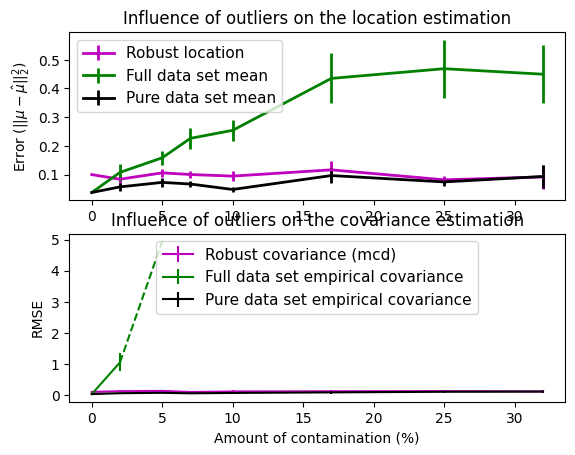

In [2]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np

from sklearn.covariance import EmpiricalCovariance, MinCovDet

# 예제 설정: 샘플 수, 특징 수, 반복 횟수 등을 설정
n_samples = 80
n_features = 5
repeat = 10

# 이상치 범위 설정: 샘플에서 이상치의 수를 나타내는 범위 설정
range_n_outliers = np.concatenate(
    (
        np.linspace(0, n_samples / 8, 5),
        np.linspace(n_samples / 8, n_samples / 2, 5)[1:-1],
    )
).astype(int)

# 결과 저장을 위한 배열 정의: 위치와 공분산 오류를 저장할 배열 초기화
err_loc_mcd = np.zeros((range_n_outliers.size, repeat))
err_cov_mcd = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_full = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_full = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_pure = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_pure = np.zeros((range_n_outliers.size, repeat))

# 계산: 각 이상치 설정에 대해 데이터 생성, 추정기 적합, 오류 계산 반복
for i, n_outliers in enumerate(range_n_outliers):
    for j in range(repeat):
        rng = np.random.RandomState(i * j)

        # 데이터 생성: 정규분포에서 무작위 샘플 생성 및 이상치 추가
        X = rng.randn(n_samples, n_features)
        outliers_index = rng.permutation(n_samples)[:n_outliers]
        outliers_offset = 10.0 * (
            np.random.randint(2, size=(n_outliers, n_features)) - 0.5
        )
        X[outliers_index] += outliers_offset
        inliers_mask = np.ones(n_samples).astype(bool)
        inliers_mask[outliers_index] = False

        # MCD robust estimator 적합 및 오류 계산
        mcd = MinCovDet().fit(X)
        # compare raw robust estimates with the true location and covariance
        err_loc_mcd[i, j] = np.sum(mcd.location_**2)
        err_cov_mcd[i, j] = mcd.error_norm(np.eye(n_features))

        err_loc_emp_full[i, j] = np.sum(X.mean(0) ** 2)
        err_cov_emp_full[i, j] = (
            EmpiricalCovariance().fit(X).error_norm(np.eye(n_features))
        )

        # 이상치를 제거한 순수 데이터셋에 대한 EmpiricalCovariance 적합 및 오류 계산
        pure_X = X[inliers_mask]
        pure_location = pure_X.mean(0)
        pure_emp_cov = EmpiricalCovariance().fit(pure_X)
        err_loc_emp_pure[i, j] = np.sum(pure_location**2)
        err_cov_emp_pure[i, j] = pure_emp_cov.error_norm(np.eye(n_features))

# 결과 표시: 위치와 공분산 추정 오류를 서브플롯으로 시각화
font_prop = matplotlib.font_manager.FontProperties(size=11)
plt.subplot(2, 1, 1)
lw = 2
plt.errorbar(
    range_n_outliers,
    err_loc_mcd.mean(1),
    yerr=err_loc_mcd.std(1) / np.sqrt(repeat),
    label="Robust location",
    lw=lw,
    color="m",
)
plt.errorbar(
    range_n_outliers,
    err_loc_emp_full.mean(1),
    yerr=err_loc_emp_full.std(1) / np.sqrt(repeat),
    label="Full data set mean",
    lw=lw,
    color="green",
)
plt.errorbar(
    range_n_outliers,
    err_loc_emp_pure.mean(1),
    yerr=err_loc_emp_pure.std(1) / np.sqrt(repeat),
    label="Pure data set mean",
    lw=lw,
    color="black",
)
plt.title("Influence of outliers on the location estimation")
plt.ylabel(r"Error ($||\mu - \hat{\mu}||_2^2$)")
plt.legend(loc="upper left", prop=font_prop)

plt.subplot(2, 1, 2)
x_size = range_n_outliers.size
plt.errorbar(
    range_n_outliers,
    err_cov_mcd.mean(1),
    yerr=err_cov_mcd.std(1),
    label="Robust covariance (mcd)",
    color="m",
)
plt.errorbar(
    range_n_outliers[: (x_size // 5 + 1)],
    err_cov_emp_full.mean(1)[: (x_size // 5 + 1)],
    yerr=err_cov_emp_full.std(1)[: (x_size // 5 + 1)],
    label="Full data set empirical covariance",
    color="green",
)
plt.plot(
    range_n_outliers[(x_size // 5) : (x_size // 2 - 1)],
    err_cov_emp_full.mean(1)[(x_size // 5) : (x_size // 2 - 1)],
    color="green",
    ls="--",
)
plt.errorbar(
    range_n_outliers,
    err_cov_emp_pure.mean(1),
    yerr=err_cov_emp_pure.std(1),
    label="Pure data set empirical covariance",
    color="black",
)
plt.title("Influence of outliers on the covariance estimation")
plt.xlabel("Amount of contamination (%)")
plt.ylabel("RMSE")
plt.legend(loc="upper center", prop=font_prop)

plt.show()